# Module 10.2: Naive Bayes and Model Construction

<div class="alert alert-block alert-warning">
<h1>Learning Objectives</h1>

**Purpose**  Introduce students to the manual construction of a model using Naive Bayes.

**Students Learn**
  * How to develop a pipeline workflow 
  * 

**Core Activities**
  * Load fingerprints into a feature matrix
  * Load labels into a target vector
  * Load and apply a variance mask
  * Split data into train and test sets

**Prior Knowledge**
  * Complete Appendix A10.2: [Bayes' Theorem: From Inference to Models](https://rebelford.github.io/2026Cheminformatics/content/appendices/App_10/A_10-2NaiveBayes.html) 
  * Familiarity with SMILES and InChI
  * Familiarity with RDKit fingerprint generation
  * Familiarity with Pandas

**Reading links**
  * [Pandas Chapter of Py4Sci](https://rebelford.github.io/py4scibook/content/module3-packages1/03-2-pandas.html) 

# 1. Preparation for model building
We are building supervised learning models to predict the biological activity of small molecules. Each molecule is represented by a set of MACCS keys, and each molecule has an associated activity label: **1 for active** and **0 for inactive**.

For a *single compound*, the model can be written as:
$$y = f(X)$$
where:
* (X) is a **feature vector** containing the MACCS keys for that compound,
* (y) is a **scalar** prediction (0 or 1),
* (f) is the learned model that maps features to an activity prediction.  

For an *entire dataset* of compounds, this generalizes to:
$$
\mathbf{y} = f(\mathbf{X})
$$
where:
* $(\mathbf{X})$ is a **feature matrix** of shape *(n_samples, n_features)*,
* $(\mathbf{y})$ is a **label vector** of length *n_samples*.

We use uppercase X to indicate that the input data is multiple descriptors

In practice, the symbol X is used generically to denote the input features. Depending on context, X may refer to:
  * a single feature vector for one compound.
  * A feature matrix containing feature vectors for many compounds

<div class="alert alert-block alert-info">
<strong>Deeper Dive:</strong> Let’s take a closer look at <em>y = f(X)</em>

  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
<summary>Explanation</summary>

<p>
The use of uppercase <b>X</b> and lowercase <b>y</b> follows a long-standing
convention in mathematics, statistics, and machine learning.
</p>

<ul>
  <li>
    <b><code>X</code> (uppercase)</b> typically represents a <b>matrix of features</b> when working with a dataset
    <ul>
      <li>Shape: <i>(n_samples, n_features)</i></li>
      <li>Each row corresponds to one compound (observation)</li>
      <li>Each column corresponds to one descriptor or fingerprint bit</li>
    </ul>
  </li>
  <br>
  <li>
    <b><code>y</code> (lowercase)</b> represents a <b>vector of target values (labels)</b>
    <ul>
      <li>Shape: <i>(n_samples,)</i></li>
      <li>Each element is the activity associated with one compound</li>
    </ul>
  </li>
</ul>

<p>In linear-algebra terms:</p>

<ul>
  <li><code>X</code> is a 2-dimensional object (a matrix)</li>
  <li><code>y</code> is a 1-dimensional object (a vector)</li>
</ul>

<p>
This naming convention reflects the canonical supervised-learning equation:
</p>

<p style="text-align: center;">
\( y = f(\mathbf{X}) \)
</p>

<p>where:</p>

<ul>
  <li>the function <code>f</code> represents a learned model</li>
  <li>the model takes a matrix of input features (<b>X</b>)</li>
  <li>and produces a vector of outputs (<b>y</b>)</li>
</ul>

<p><b>In short:</b></p>

<ul>
  <li><b>Uppercase <code>X</code></b> → feature matrix</li>
  <li><b>Lowercase <code>y</code></b> → target vector</li>
</ul>

<p>
This convention is not enforced by Python, but it is widely adopted and helps
communicate the structure of the data at a glance.
</p>

</details>
</div>
</div>


## 1.1 Loading the data into X and y.

In [1]:
import pandas as pd
# read fingerprints with activities csv file into pandas dataframe
df_data = pd.read_csv("data/AID743139/features/AID743139_MACCS_activites_noSalt_20260118_v1.csv") # Change to your file path if you need to load the dataframe

# we now have a dataframe with CIDS, activities and maccs keys
print(df_data.shape)
df_data.head(3)

(6793, 170)


,cid,activity,clean_smiles,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
0,12850184,0,O=C(CO)[C@@H](O)[C@H](O)[C@@H](O)C(=O)[O-],0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,89753,0,O=C([O-])[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,9403,0,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


We will put the MACCS Keys into a variable called X_MACCS, the feature Matrix.<br>
We will put the activity values into a variable called y, the label vector.

In [2]:
X_MACCS = df_data.iloc[:,3:] # this is dropping cid, activity, and clean_smiles and creating a new variable for maccs data
y = df_data['activity'].values # note, df_data is a pd dataframe, but .values makes it a np array

In [3]:
# Print head of feature matrix
X_MACCS.head(3)

,maccs000,maccs001,maccs002,maccs003,maccs004,maccs005,maccs006,maccs007,maccs008,maccs009,...,maccs157,maccs158,maccs159,maccs160,maccs161,maccs162,maccs163,maccs164,maccs165,maccs166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


In [7]:
import numpy as np
print(y[:5])# prints first 5 values of the label vector 
print(np.unique(y)) # prints all unique values of label vector

[0 0 0 0 0]
[0 1]


In [12]:
# Write the code to print length of label vector (y) and number of active compounds (hint, they are zeros and ones, so you can sum them)
print(len(y))
print(y.sum())

6793
743


## 1.2 Feature Selection: Remove zero-variance features

Some features in X are not helpful in distinguishing actives from inactives, because they are set ON for all compounds or OFF for all compounds.  Such features need to be removed because they would consume more computational resources without improving the model.

We will use the `VarianceThreshold` method of sklearn to identify which features have a variance of zero or very low. Variance in data represents how spread out the values of a feature are. The `threshold` parameter is set to 0.0 by default, meaning only features with zero variance (constant values across all samples, 100% identical values) are removed. 

<div class="alert alert-block alert-info">
    
<strong>What if a feature has ≥99% identical values?</strong>
   <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">       
<details>
<summary>Explanation</summary>
Let’s say a feature is <code>1</code>  in 99.5% of rows and <code>0</code>  in the remaining 0.5%. It does not have zero variance, but the variance is very low.

If you want to remove such near-constant features, you need to set <code>threshold</code> accordingly. In this case the variance is calculated as:
<center>Var(X)=<i>p</i>(1−<i>p</i>)=0.995×(1−0.995)=0.004975<br>
where <i>p</i> is probability of the feature being 1</center>


So to remove this feature, your threshold must be greater than 0.004975, for example:
<code>VarianceThreshold(threshold=0.005)</code>

It might be interesting to see how our models change, or time calculating the model changes if we do some prefiltering by adjusting the threshold.


In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
X_MACCS.shape  #- Before removal

(6793, 167)

In [15]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Apply variance threshold
sel = VarianceThreshold(threshold=0.0)
X_MACCS_filtered = sel.fit_transform(X_MACCS)

# Boolean mask of retained features
mask = sel.get_support()

# Human-readable feature names
kept_features = X_MACCS.columns[mask]
removed_features = X_MACCS.columns[~mask]

print("Features removed:", list(removed_features))
print("Filtered feature matrix shape:", X_MACCS_filtered.shape)

# ---- FEATURE METADATA (generated here) ----
feature_metadata = {
    "fingerprint": "MACCS",
    "original_bits": X_MACCS.shape[1],
    "selected_bits": int(mask.sum()),
    "removed_bits": int((~mask).sum()),
    "selection_method": "VarianceThreshold",
    "threshold": 0.0,
    "removed_feature_names": list(removed_features),
    "source_file": "AID743139_MACCS_activites_noSalt_20260104_v1.csv",
    "notes": "Invariant MACCS bits removed prior to modeling"
}


Features removed: ['maccs000', 'maccs001', 'maccs002', 'maccs004', 'maccs166']
Filtered feature matrix shape: (6793, 162)


<div class="alert alert-block alert-info">
<strong>Check your understanding</strong>

A MACCS fingerprint has 166 bit positions but the RDKit MACCS fingerprint has 167. This position has zeros for all molecules and is removed regardless of the threshold, can you think of why this position is set to zero?
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
<summary>Answer</summary>
The <code>maccs000</code> position is always zero because it is a
<strong>dummy bit</strong> added by RDKit for bookkeeping purposes.
<p>The canonical MACCS fingerprint defines 166 chemically meaningful
keys numbered 1–166 (not 167).</p>

<p>By including a zero-valued bit at position 0, RDKit allows the bit index
to match the MACCS key number directly (e.g., bit 1 → MACCS key 1),
avoiding off-by-one confusion when labeling features.</p> Because this dummy bit carries no chemical information and has zero
variance across all molecules, it is removed during feature preprocessing.
</details>
</div>
</div>


## 1.3 Feature Selection: Freezing the Feature Definition (Mask and Metadata)

Up to this point, we have generated MACCS fingerprints for all compounds and examined which fingerprint bits vary across the dataset. When we remove invariant bits using a variance filter, we are no longer just manipulating data—we are defining the feature space that every downstream model will use. From this moment forward, a “feature” has a specific meaning: it is one of the MACCS bits that survived this filtering step. This process is known as feature selection: deciding which descriptors are informative enough to be included in the model and which should be excluded.


Because this feature selection step is learned from the data, it must be treated as part of the scientific record. Any model trained on these data—whether Naive Bayes, Decision Trees, or future methods—must use exactly the same feature definition in order to be valid and comparable. To ensure reproducibility and avoid hidden assumptions, we explicitly save the feature mask (a Boolean array indicating which MACCS bits were kept or removed) as a numpy file, along with descriptive metadata explaining how and why the selection was performed as a json file.

By freezing the feature definition here (meaning it will not change for this dataset), we create a clear boundary between data preparation and modeling. All subsequent notebooks and models will load and reuse this saved feature definition rather than recomputing it, guaranteeing that results remain consistent even across kernel restarts, new environments, or alternative machine-learning methods.

In [16]:
from pathlib import Path
import json
import numpy as np
import pchelpfct as pchf

PROJECT_ROOT = Path.cwd()  # current working directory
FEATURES = PROJECT_ROOT / "data" / "AID743139" / "features"
FEATURES.mkdir(parents=True, exist_ok=True)

# Save variance mask
mask_fname = pchf.make_filename(
    prefix="AID743139_MACCS_variance_mask",
    ext="npy",
    folder=str(FEATURES)
)
np.save(FEATURES / mask_fname, mask)

# Save metadata JSON
meta_fname = pchf.make_filename(
    prefix="AID743139_MACCS_feature_metadata",
    ext="json",
    folder=str(FEATURES)
)
with open(FEATURES / meta_fname, "w") as f:
    json.dump(feature_metadata, f, indent=2)

print(f"[Saved] Variance mask → {mask_fname}")
print(f"[Saved] Feature metadata → {meta_fname}")


[Saved] Variance mask → /home/rebelford/jupyterbooks/cinf26book/content/modules/10_SupervisedML/data/AID743139/features/AID743139_MACCS_variance_mask_20260128_v1.npy
[Saved] Feature metadata → /home/rebelford/jupyterbooks/cinf26book/content/modules/10_SupervisedML/data/AID743139/features/AID743139_MACCS_feature_metadata_20260128_v1.json


<div class="alert alert-block alert-success">
<strong>Code Dive</strong>
<p>Explain the role of the following three files in the features directory. These three files together define the feature representation and labeling scheme used for model training and evaluation. They must be treated as a matched set.
</p>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>AID743139_MACCS_activites_noSalt_.csv</summary>
This CSV file contains the core machine-learning dataset. Each row corresponds to a single PubChem compound (CID) and includes:
<ul>
    <li>The PubChem Compound ID (CID)</li>
    <li>A binary activity label (0 = inactive, 1 = active) derived from the assay outcomes</li>
    <li>A MACCS fingerprint vector, which will be used to construct the feature matrix (X) for model training</li>
</ul>
The MACCS fingerprints were generated from salt-stripped molecules, keeping only the largest molecular fragment so that counterions and formulation artifacts do not influence the feature representation. This file is the direct input to scikit-learn for building and evaluating classification models.
</details>
</div>

  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>AID743139_MACCS_feature_metadata_.json</summary>
This JSON file records the feature-engineering decisions applied to the MACCS fingerprints. It serves as documentation and provenance for how the feature matrix was constructed.

Typical contents include:
<ul>
    <li>Which MACCS bit positions were removed (e.g., invariant bits such as MACCS000)</li>
    <li>The reason for removal (e.g., zero variance across all compounds)</li>
    <li>The original fingerprint length and the final feature count</li>
    <li>Any parameters or assumptions used during fingerprint processing</li>
</ul>
This file allows us to:
<ul>
    <li>Reproduce the feature matrix exactly</li>
    <li>Understand why certain bits are missing</li>
    <li>Apply the same preprocessing rules to future datasets or external test compounds</li>
</ul>
</details>
</div>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>AID743139_MACCS_variance_mask_.npy</summary>
<p>
This NumPy file contains the Boolean variance mask used to filter the MACCS fingerprints. The mask is a 1-D array with one entry per original MACCS bit:
<ul>
    <li>True → keep this bit</li>
    <li>False → drop this bit</li>
</ul>
During feature construction, this mask is applied to every fingerprint so that only informative (non-invariant) features are retained. The mask is the operational object that enforces the rules described in the metadata JSON.
This file is used programmatically to:
<ul>
    <li>Transform raw MACCS fingerprints into the final feature matrix</li>
    <li>Ensure consistency between training data, test data, and future predictions</li>
</ul>
</p>
</details>
</div>
</div>


## 1.4 Reload Data
**Where we are in the Supervised Learning Pipeline**
In this module, we are continuing a supervised learning pipeline that began with data preparation. We first downloaded BioAssay data from PubChem and stored the unmodified exports in the `/raw` directory. We then curated these data to remove invalid records and standardize chemical representations, saving the cleaned results in `/curated`. From this curated dataset, we generated molecular fingerprints (MACCS keys) and applied feature-level filtering to remove invariant bits, producing a refined feature representation. The resulting fingerprint dataset, along with the feature-selection mask and metadata documenting how the features were constructed, was saved in the `/features` directory as non-volatile `.csv` and `.npy` files. In the current notebook, we reload these saved feature artifacts and use them to define train/test splits, which establish the experimental framework for the modeling activities that follow. These splits will support multiple supervised learning models—such as Naive Bayes, Decision Trees, Random Forests, and k-Nearest Neighbors—while ensuring that all models are trained and evaluated on a consistent molecular representation.

Note: In this notebook, the term pipeline refers to a conceptual workflow, a sequence of data transformations and modeling steps applied consistently. In later notebooks, this workflow will be formalized into reusable and scalable pipeline objects.
### 1.4.1 Regenerate X_MACCS
 * X_MACCS is the original unfiltered feature matrix
 * This is the "ground truth representation"

In [17]:
# Step 1 Load source feature data
import pandas as pd

df_data = pd.read_csv(
    "data/AID743139/features/AID743139_MACCS_activites_noSalt_20260118_v1.csv"
)# adjust code to your file

# Separate labels
y = df_data["activity"].values

# Reconstruct full MACCS feature matrix
X_MACCS = df_data.iloc[:, 3:]  # CID, activity, clean_smiles dropped

print(X_MACCS.shape)


(6793, 167)


### 1.4.2 Load and apply saved variance mask
* Mask is 1D
* length must equal `X_MACCS.shape[1]`

In [18]:
import numpy as np

# Load saved variance mask
mask = np.load(
    "data/AID743139/features/AID743139_MACCS_variance_mask_20260125_v1.npy"
)# adjust code to your file path

print("Mask shape:", mask.shape)
print(mask.sum(), "features retained")

# Safety check: ensure mask matches feature matrix
assert X_MACCS.shape[1] == mask.shape[0], (
    "Incompatible feature mask: "
    "mask length does not match number of MACCS features. "
    "Check that the CSV and mask were generated from the same dataset."
)



Mask shape: (167,)
162 features retained


### 1.4.3 Reconstruct the filtered feature matrix `X_MACCS_filtered`
In this step, we reconstruct the filtered MACCS feature matrix by reapplying a previously learned transformation. No feature selection is performed here; instead, we reuse the saved variance mask to ensure that the exact same feature definition is recovered after a kernel restart. The reconstruction is performed using a Pandas DataFrame so that feature alignment and consistency can be verified. Once feature semantics are finalized, the filtered feature matrix is explicitly converted to a NumPy array in preparation for downstream modeling, where only numeric operations are required.

In [19]:
X_MACCS_filtered = X_MACCS.loc[:, mask]

print(X_MACCS_filtered.shape)

# Decide representation for modeling
X_MACCS_filtered = X_MACCS_filtered.to_numpy()   # <-- optional but explicit

(6793, 162)


## 1.5 Train-Test-Split (a 9:1 ratio) 
Now that we’ve prepared the dataset, the next step is to divide it into two parts: one for training the model and one for testing it. This is important because we want to evaluate how well the model performs on unseen data, and not just the data it was trained on.

This is typically done by splitting the dataset into two subsets using a specified ratio. Common splits include 80:20 or 70:30, where the larger portion is used for training and the smaller for testing. When the dataset is small or the model requires more examples to learn effectively, a 90:10 split can be helpful.

In the next code section, we will split the data so that 90% goes into the training set and 10% into the test set. The training set is used to build the model, while the test set is used to evaluate how well the model generalizes to new data. Sklearn's `train_test_split` creates several NumPy arrays at once by applying the same randomized split to aligned data. We include the DataFrame index so we can recover which chemical compounds ended up in the training and test sets.

It is important that this train–test split is performed before any model-building decisions, such as class balancing, downsampling, or
reweighting. These operations will later be applied only to the training data, never to the test data. By splitting the dataset at this stage and saving the resulting arrays, we preserve an untouched test set that represents the original data distribution. This ensures that model evaluation reflects true generalization performance rather than artifacts introduced during training.

The following table summarizes the key parameters used in the upcoming `train_test_split()` call. Review these options before running the code, as they determine how the training and test sets are constructed.

| **Parameter** | **Value Used** | **Purpose in This Workflow** |
|---------------|----------------|-------------------------------|
| `X_MACCS_filtered` | feature matrix | The input feature matrix containing MACCS fingerprints after variance filtering. |
| `y` | label vector | Binary activity labels (0 = inactive, 1 = active) aligned row-by-row with `X`. |
| `df_data.index` | row identifiers | Preserves the original row identity so compounds can be traced after splitting. |
| `test_size` | `0.1` | Holds out 10% of the data for testing, leaving 90% for training. |
| `shuffle` | `True` | Randomizes the order of samples before splitting to avoid ordering bias. |
| `random_state` | `3100` | Fixes the random number generator seed so the split is reproducible. |
| `stratify` | `y` | Ensures the training and test sets retain the same active/inactive class ratio as the original dataset. |

In particular, the `stratify=y` argument is critical for classification problems with class imbalance. It guarantees that both the training and test sets reflect the original class distribution, preventing accidental bias in model evaluation caused by uneven splits.



In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_MACCS_filtered,
    y,
    df_data.index,     # preserve row identity across the split
    shuffle=True,
    random_state=3100, # make the split reproducible
    stratify=y,        # preserve class balance
    test_size=0.1      # 10% of data held out for testing
)



In [21]:
print("Training set shape:", X_train.shape, y_train.shape)
print("where there are", X_train.shape[0], "samples, and", X_train.shape[1], "features")
print("and", y_train.shape[0], "activities associated with the training set.")
print()
print("Test set shape:", X_test.shape, y_test.shape)
print("where there are", X_test.shape[0], "samples, and", X_test.shape[1], "features")
print("and", y_test.shape[0], "activities associated with the test set.")
print()
print("Number of active compounds in training set:", y_train.sum())
print("Number of active compounds in test set:", y_test.sum())

Training set shape: (6113, 162) (6113,)
where there are 6113 samples, and 162 features
and 6113 activities associated with the training set.

Test set shape: (680, 162) (680,)
where there are 680 samples, and 162 features
and 680 activities associated with the test set.

Number of active compounds in training set: 669
Number of active compounds in test set: 74


<div class="alert alert-block alert-success"> 
<strong>Code Check:</strong> <p>What does this line of code do?</p>  
    
```python
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_MACCS,
    y,
    df_data.index,     # preserve row identity across the split
    shuffle=True,
    random_state=3100, # make the split reproducible
    stratify=y,        # preserve class balance
    test_size=0.1      # 10% of data held out for testing
))
```
<br>
    
<div class="alert alert-block alert-info">
<details>
    <summary>Explanation</summary>

This line calls scikit-learn’s train_test_split() function to partition the data into training and test sets in a way that is safe for machine learning.

Before this line:
  * X_MACCS_filtered is a 2-D numerical array (or array-like object) containing molecular features
(rows = compounds, columns = MACCS fingerprint bits).
  * y is a 1-D numerical array containing the corresponding activity labels
(one value per compound).

**What train_test_split() does:**

  1. Splits the rows of X and y together so that each compound’s feature vector stays paired with its activity label.
  2. Creates four NumPy arrays
     * X_train – feature matrix used to train the model
     * X_test – feature matrix held back for evaluation
     * y_train – activity labels for the training set
     * y_test – activity labels for the test set
     * idx_train  - row numbers of training samples
     * idx_test - row numbers of test samples
  3. Uses NumPy-style array slicing internally.
       Which is why the outputs expose NumPy attributes like .shape.
  4. Shuffles the data before splitting (shuffle=True).
       This prevents ordering artifacts (e.g., all actives grouped together).
  5. Preserves class balance (stratify=y).
       The fraction of active vs. inactive compounds is maintained in both the training and test sets.
  6. Ensures reproducibility (random_state=3100).
       The same split will be generated every time this code is run.
  7. Reserves 10% of the data for testing (test_size=0.1)
       The remaining 90% is used for model training.
  8. We removed CID, Index and SMILES and so there is no way to go back to which chemical is which, and idx_train/test does that   

In short, this single line converts your feature table and labels into four NumPy arrays structured exactly the way scikit-learn expects, establishing the data layout used throughout machine-learning workflows.                                                                     |


</details>
</div>
</div>


#### 1.5.1 Save the test/train split as np arrays

In [22]:
from pathlib import Path
import numpy as np
import json

# Project root
PROJECT_ROOT = Path.cwd()  # 10_ML

# Define split directory
SPLIT_NAME = "90_10"
SPLITS = PROJECT_ROOT / "data" / "AID743139" / "splits" / SPLIT_NAME
SPLITS.mkdir(parents=True, exist_ok=True)

# Optional subfolder for arrays (keeps things tidy)
ARRAYS = SPLITS / "arrays"
ARRAYS.mkdir(exist_ok=True)

# Save NumPy arrays
np.save(ARRAYS / "X_train.npy", X_train)
np.save(ARRAYS / "X_test.npy", X_test)
np.save(ARRAYS / "y_train.npy", y_train)
np.save(ARRAYS / "y_test.npy", y_test)

# Save index mappings (critical for traceability)
np.save(SPLITS / "train_idx.npy", idx_train)
np.save(SPLITS / "test_idx.npy", idx_test)

# Save CID traceability
df_data.loc[idx_train, ["cid"]].to_csv(
    SPLITS / "train_cids.csv",
    index=False 
)

df_data.loc[idx_test, ["cid"]].to_csv(
    SPLITS / "test_cids.csv",
    index=False
)

# Save split metadata
split_metadata = {
    "assay": "AID743139",
    "split_name": SPLIT_NAME,
    "description": "Stratified 90/10 train/test split",
    "test_fraction": 0.10,
    "train_fraction": 0.90,
    "stratified": True,
    "random_state": 3100,
    "labels": "Active vs Inactive",
    "features": "MACCS (variance-filtered)",
    "source_feature_file": "AID743139_MACCS_activites_noSalt_20260104_v1.csv"
}

with open(SPLITS / "split_metadata.json", "w") as f:
    json.dump(split_metadata, f, indent=2)

print(f"[Saved] Train/test split → {SPLITS}")


[Saved] Train/test split → /home/rebelford/jupyterbooks/cinf26book/content/modules/10_SupervisedML/data/AID743139/splits/90_10


The train/test split produces several files that serve different roles in the
machine-learning workflow. Some are used directly for model training, while
others preserve traceability, reproducibility, and interpretability. The table
below summarizes what was saved and why.

| **Purpose** | **Files** | **Why They Exist** |
|-------------|-----------|-------------------|
| **Model inputs** | `X_train.npy`, `y_train.npy`<br>`X_test.npy`, `y_test.npy` | Numerical feature matrices and label vectors used directly for model training and evaluation. |
| **Operational split definition** | `train_idx.npy`, `test_idx.npy` | Exact row indices used to construct the split, allowing it to be verified, reconstructed, or reused. |
| **Chemical identity traceability** | `train_cids.csv`, `test_cids.csv` | Maps rows in the NumPy arrays back to compound identifiers for inspection, reporting, and auditing. |
| **Provenance & metadata** | `split_metadata.json` | Documents how the split was created, including parameters and source files, as part of the scientific record. |

Not all of these files are used immediately in this notebook. Some exist to support later model evaluation, interpretation, or reproducibility, and will be revisited in subsequent sections and notebooks.

<div class="alert alert-block alert-success">
<strong>Data Artifacts Dive: What was Saved and Why</strong>
<p>Explain the role of the following files in the splits/90_10 directory. <strong>Be sure to open the files!</strong> You can open the *.csv and *.json files directly from the jupyter lab file browser.  You can open the *.npy files by executing the following in a code cell (and altering file name as appropriate).
<pre><code>
import numpy as np
from pathlib import Path

PROJECT_ROOT = Path.cwd()  # 10_ML

SPLIT_NAME = "90_10"
SPLITS = PROJECT_ROOT / "data" / "AID743139" / "splits" / SPLIT_NAME
test_idx = np.load(SPLITS / "arrays/X_test.npy")
test_idx
</code></pre>
The first three file types define the feature representation and labeling scheme used for model training and evaluation. They must be treated as a matched set.
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">

<details>
    <summary>split_metadata.json</summary>
Documents how the split was performed
<ul>
    <li>Train/test ratio (90/10)</li>
    <li>Random seed used</li>
    <li>Apply stratification (maintain same active/inactive ratio of test and train sets as was in the original set</li>
    <li>Source feature file name</li>
</ul>
</details>
</div>

  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>train_cids.csv and test_cids.csv</summary>
Identify which compounds (CIDs) ended up in test and traing set.
These files are for:
<ul>
    <li>Inspection</li>
    <li>Reporting</li>
    <li>Debugging</li>
</ul>
</details>
</div>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>train_idx.npy and test_idx.npy</summary>
<p>
The train and test index files define the data split operationally by storing the exact row positions used to slice the feature matrix (X) and label vector (y). Applying these indices guarantees that every model, even when developed in different notebooks or with different algorithms, is trained and evaluated on the exact same compounds. Chemical identifiers such as CIDs are stored separately for interpretation and auditing, but the model itself only ever sees rows of numerical features selected by these indices.

Once the split has been applied and saved as training and test arrays, the index files are no longer needed for routine model training or evaluation. They are retained as permanent artifacts to support traceability, auditing, and reproducibility, allowing the split to be verified, reconstructed, or reused if the feature representation is regenerated in the future.
</p>
</details>
</div>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>X_train.npy and y_train.npy</summary>
<p>
These files contain the training data used to build machine-learning models.
X_train.npy is a NumPy array representing the feature matrix, where each row corresponds to a compound and each column corresponds to a MACCS fingerprint bit retained after variance filtering. y_train.npy is the label vector, containing the binary activity labels (0 = inactive, 1 = active) for the same compounds, in the same row order.

These arrays are the direct inputs to model fitting (e.g., model.fit(X_train, y_train)). The training data may later be balanced, weighted, or resampled, depending on the modeling strategy, but these files preserve the original, stratified train split exactly as defined.
To open and view the content of one of these file you can use the following command
<pre><code>
import numpy as np
y_train = np.load("y_train.npy")
y_train[:5]
</code></pre>
(Note: you have to set the path to the correct file location)
</p>
</details>
</div>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>X_test.npy and y_test.npy</summary>
<p>
These files contain the held-out test data used to evaluate model performance.
X_test.npy is the feature matrix for the test compounds, and y_test.npy contains their corresponding activity labels, aligned row-by-row with the feature matrix.

The test arrays are never modified (no balancing or resampling) and are used only for prediction and evaluation (e.g., confusion matrices, ROC curves, precision/recall). Because they were created using a stratified split, they reflect the natural class distribution of the dataset and provide an unbiased assessment of model generalization.
</p>
</details>
</div>
</div>


In [23]:
# Write code here to view a *.npy files in the arrays folder (see above hints)

**Looking Ahead: Preparing Data for Model Building**

In the next section, we will reload these saved training and test arrays and
begin preparing the training data for model construction. One common challenge
in biological activity datasets is class imbalance, where the number of
inactive compounds greatly exceeds the number of active compounds. When left
unaddressed, this imbalance can cause a model to favor the dominant (majority)
class rather than learning meaningful patterns associated with activity.

We will explore strategies for addressing this issue using only the training
data, while keeping the test set unchanged so that model evaluation remains
unbiased.


# 2. Preparing the Training Data Model Construction
In this section, we focus exclusively on the training data and the preprocessing steps that are permitted during model construction.
Unlike earlier steps, where we defined the feature space and created a fixed train–test split, the operations introduced here may intentionally modify the training data to help the model learn more effectively.

A key principle governs all steps in this section: **the test set is never altered**. Any transformations, resampling, or adjustments are applied only to the training data, ensuring that model evaluation remains unbiased and reflects performance on unseen data.

## 2.1 Reload the Saved Training and Test Arrays
If you are continuing directly from Section 1 without restarting the kernel, the training and test arrays may already be in memory. However, it is important that you know how to reload these arrays from disk in case the kernel has been restarted or you are returning to the notebook at a later time. For that reason, we begin this section by explicitly loading the saved NumPy arrays. If the arrays are already in memory, you may treat this step as a demonstration of how the data can be recovered when needed.


In [24]:
from pathlib import Path
import numpy as np

# Define project root (10_ML)
PROJECT_ROOT = Path.cwd()

# Define arrays directory
ARRAY_DIR = (
    PROJECT_ROOT
    / "data"
    / "AID743139"
    / "splits"
    / "90_10"
    / "arrays"
)

# Load arrays into active memory
X_train = np.load(ARRAY_DIR / "X_train.npy")
y_train = np.load(ARRAY_DIR / "y_train.npy")

X_test  = np.load(ARRAY_DIR / "X_test.npy")
y_test  = np.load(ARRAY_DIR / "y_test.npy")

X_train.shape, y_train.shape


((6113, 162), (6113,))

<div class="alert alert-block alert-info">
<strong>What does it mean to load a Numpy Array</strong>

<p>The following code loads two objects into memory. Explain what these objects are, where they come from, and how they are used in the machine-learning workflow.
</p>
<pre><code>X_train = np.load(ARRAY_DIR / "X_train.npy")
y_train = np.load(ARRAY_DIR / "y_train.npy")</code></pre>
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Answer</summary>
    
 <p>
    The files <code>X_train.npy</code> and <code>y_train.npy</code> store NumPy arrays
    on disk. These files are <em>persistent</em>, meaning they remain available even
    after the kernel is restarted or the notebook is closed.
  </p>

  <p>
    When <code>np.load()</code> is called, the data in these files are read from disk
    and loaded into active memory as the variables <code>X_train</code> and
    <code>y_train</code>. At this point, they are ordinary NumPy arrays
    (<code>numpy.ndarray</code>) that can be passed directly to machine-learning
    algorithms.
  </p>

  <p>
    Although one representation exists on disk (nonvolatile) and the other exists in
    memory (volatile), they are structurally identical. Once loaded, the model cannot
    distinguish whether a NumPy array was created by computation or loaded from a file.
  </p>

</details>
</div>
</div>

## 2.2 Examine class imbalance
### 2.2.1 What is class imbalance and why it matters
Before training a classification model, it is important to examine the distribution of class labels in the training set. In many biological datasets, the number of inactive compounds far exceeds the number of active compounds. This situation is known as class imbalance.

When class imbalance is present, a model may appear to perform well overall while failing to correctly identify the minority class. For example, a model trained on highly imbalanced data may learn to predict the majority class (typically inactives) most of the time, resulting in misleading accuracy and poor detection of the minority class (typically active compounds). By quantifying the class distribution early, we can assess the severity of imbalance and decide whether additional steps are needed to support effective model learning.

<div class="alert alert-block alert-success"> 
<strong>Deeper Dive:</strong> Strategies for Handling Imbalanced Data
    
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Strategies</summary>

Many classification problems involve **imbalanced datasets**, where one class occurs much more frequently than another.

If untreated, imbalance can cause models to:
* Favor the majority class
* Misclassify rare but important samples
* Produce misleading accuracy metrics

---

 **Common strategies**

There are three broad approaches to handling class imbalance:

**1. Downsampling (Under-sampling)**
* Randomly remove samples from the majority class
* Simple and effective
* Risk: loss of potentially useful information

**2. Oversampling**
* Increase the size of the minority class
* Can be done by duplication or synthetic methods (e.g., SMOTE)
* Risk: overfitting to replicated or artificial samples

**3. Cost-sensitive learning**
* Penalize misclassification of the minority class more heavily
* Often implemented via class weights
* Keeps all data but changes the learning objective

---

**Key takeaway**

Handling class imbalance is not about maximizing accuracy; it is about shaping the decision boundary so that the assignment of class labels y to feature vectors X is driven by meaningful feature patterns, not by class frequency alone.

</details>
</div>
</div>


### 2.2.2 Measuring Class Imbalance in the Training Set

To understand the severity of class imbalance in this dataset, we examine the number of inactive and active compounds in the training set and compute their ratio.


In [26]:
print("# inactives in training set: ", len(y_train) - y_train.sum())
print("# actives in training set:   ", y_train.sum())
ratio = (len(y_train) - y_train.sum())/y_train.sum()
print("the ratio of inactive to active in training set=", ratio)

# inactives in training set:  5444
# actives in training set:    669
the ratio of inactive to active in training set= 8.137518684603886


<div class="alert alert-block alert-info">


<details>
<summary>How to interpret class balance ratios.</summary>

| **Ratio**|  **How to Interpret the Value** |
|----------:|---------------------------------|
|1|Balanced: Roughly equal number of active and inactive. Ideal for training|
|2|Mild imbalance: 1 active for every 2 inactives. Still manageable, but performance of minority class should be monitored.|
|5| Severe imbalance. Model may predict majority class most of the time and ignore the minority class.|

Before applying any balancing strategy, it is important to keep the following workflow principles in mind:
* Always save unbalanced train/test splits
* Never balance the test set
* Treat balancing as part of the model, not the data
* Expect some variability when downsampling
* Use fixed seeds when debugging, variable seeds when evaluating robustness


## 2.3 Balance the Training Set by Downsampling

When a dataset exhibits strong class imbalance, one common mitigation strategy is downsampling the majority class. In downsampling, we randomly select a subset of the majority class so that its size is comparable to that of the minority class. This encourages the model to learn decision boundaries that treat both classes more equitably, rather than defaulting to predictions driven primarily by class frequency.

Downsampling reduces the total amount of training data and may discard potentially informative samples from the majority class. However, it often improves a model’s ability to recognize the minority class and reduces bias toward the dominant class. In this notebook, we use downsampling as a simple, transparent strategy to address class imbalance during model training.

Importantly, this procedure is applied only to the training data. The test set remains unchanged and continues to reflect the original class distribution.


## 2.3 Balance the training set by downsampling
When a dataset has a strong class imbalance a common mitigation strategy is downsampling the majority class. In downsampling, we randomly select a subset of the majority class so that its size is comparable to that of the minority class. This encourages the model to learn decision boundaries that treat both classes more equitably, rather than defaulting to predictions dominated by the majority class. While downsampling reduces the total amount of training data and may discard potentially informative samples from the majority class, it often improves model performance on the minority class and reduces bias toward the majority class.

In the code cell below, we randomly select a subset of the inactive compounds such that their number matches the number of active compounds.

In [28]:
# Indices of each class
idx_inactives = np.where(y_train == 0)[0]
idx_actives   = np.where(y_train == 1)[0]

# Number of observations in each class
num_inactives = len(idx_inactives)
num_actives   = len(idx_actives)

# Downsample inactives to match number of actives
np.random.seed(0)
idx_inactives_downsampled = np.random.choice(
    idx_inactives,
    size=num_actives,
    replace=False
)

# Create balanced training set
X_train_bal = np.vstack((
    X_train[idx_inactives_downsampled],
    X_train[idx_actives]
))

y_train_bal = np.hstack((
    y_train[idx_inactives_downsampled],
    y_train[idx_actives]
))

# Confirm balancing worked
print("# inactives:", len(y_train_bal) - y_train_bal.sum())
print("# actives:  ", y_train_bal.sum())

ratio = (len(y_train_bal) - y_train_bal.sum()) / y_train_bal.sum()
print("ratio inactive to active =", ratio)

print("\nTraining set shape:")
print("X:", X_train_bal.shape)
print("y:", y_train_bal.shape)


# inactives: 669
# actives:   669
ratio inactive to active = 1.0

Training set shape:
X: (1338, 162)
y: (1338,)


<div class="alert alert-block alert-info">
<strong>Check Your Understanding: Interpreting the Effect of Balancing</strong>
<p>
The following is <em>sample output</em> from this dataset before and after
downsampling. Your exact values may differ if a different random seed or
dataset version is used.
</p>
<table style="border-collapse: collapse; width: 100%; margin-top: 10px;">
  <thead>
    <tr style="background-color: #f2f2f2;">
      <th style="border: 1px solid #cccccc; padding: 8px;">Training Set</th>
      <th style="border: 1px solid #cccccc; padding: 8px;"># Inactives</th>
      <th style="border: 1px solid #cccccc; padding: 8px;"># Actives</th>
      <th style="border: 1px solid #cccccc; padding: 8px;">Inactive : Active Ratio</th>
      <th style="border: 1px solid #cccccc; padding: 8px;">X Shape</th>
      <th style="border: 1px solid #cccccc; padding: 8px;">y Shape</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #cccccc; padding: 8px;">
        Original (Unbalanced)
      </td>
      <td style="border: 1px solid #cccccc; padding: 8px;">5444</td>
      <td style="border: 1px solid #cccccc; padding: 8px;">669</td>
      <td style="border: 1px solid #cccccc; padding: 8px;">≈ 8.1 : 1</td>
      <td style="border: 1px solid #cccccc; padding: 8px;">
        (6113, 162)
      </td>
      <td style="border: 1px solid #cccccc; padding: 8px;">
        (6113,)
      </td>
    </tr>
    <tr>
      <td style="border: 1px solid #cccccc; padding: 8px;">
        Balanced (Downsampled)
      </td>
      <td style="border: 1px solid #cccccc; padding: 8px;">669</td>
      <td style="border: 1px solid #cccccc; padding: 8px;">669</td>
      <td style="border: 1px solid #cccccc; padding: 8px;">1 : 1</td>
      <td style="border: 1px solid #cccccc; padding: 8px;">
        (1338, 162)
      </td>
      <td style="border: 1px solid #cccccc; padding: 8px;">
        (1338,)
      </td>
    </tr>
  </tbody>
</table>
Answer the Following Questions:
<p>1. What was the original set balanced or unbalanced and identify the majority and minority classes </p>
<div style="
  background-color: #efffff;
  color: #000000;
  padding: 10px;
  border-radius: 4px;
  border: 1px solid #dddddd;
  margin-top: 10px;
">
<details>
<summary>Answer</summary>

<p>
The initial data set was highly imbalanced with 8 Inactives (majority class) for each active (minority class).
</p>
</details>
</div>

<p>2. Explain from the data how downsampling worked</p>
<div style="
  background-color: #efffff;
  color: #000000;
  padding: 10px;
  border-radius: 4px;
  border: 1px solid #dddddd;
  margin-top: 10px;
">
<details>
<summary>Answer</summary>

<p>
Initially there were 5,444 inactives and 669 actives in the dataset.  The downsampling reduced the number of unbalanced to the number of balanced, giving 669 compounds of each class, with a total dataset of 1338 compounds.  
</p>
</details>
</div>


<p>3. Can you explain the shape of the feature matrix and label vector and what data they contain?</p>
<div style="
  background-color: #efffff;
  color: #000000;
  padding: 10px;
  border-radius: 4px;
  border: 1px solid #dddddd;
  margin-top: 10px;
">
<details>
<summary>Answer</summary>

<p>
<ul>
  <li>The feature matrix</li>
    <ul>
      <li>Contains 162 columns representing the MACCS fingerprints after the zero-variance mask was applied.</li>
       <li>Each row represents a compound</li>
       <li>The original training se contains 6113 compounds</li>
       <li>The balanced (downsampled) training set contains 1338 compounds</li>
    </ul>
</li>
    <li> The label vector contains the Boolean value to indicate a compound is active (1) or inactive (0)</li>
</ul>    
</p>

</details>
</div>
<p>4. Do the balanced feature matrix (<code>X_train_bal</code>) or label vector
(<code>y_train_bal</code>) contain the chemical identity (e.g., CID) of each
compound? If not, why is this information absent, and how could the chemical
identity of a specific row be recovered if needed?</p>
<div style="
  background-color: #efffff;
  color: #000000;
  padding: 10px;
  border-radius: 4px;
  border: 1px solid #dddddd;
  margin-top: 10px;
">
<details>
<summary>Answer</summary>
<p>
No. Neither the feature matrix (<code>X_train_bal</code>) nor the label vector (<code>y_train_bal</code>) contains explicit chemical identity information such as CIDs or SMILES strings. These NumPy arrays store only numerical data: fingerprint bits in <code>X</code> and binary activity labels in <code>y</code>.
</p>

<p>
This separation is intentional. Machine-learning models operate on numerical feature vectors and labels, not on compound identifiers. Including chemical identity directly in the feature or label arrays would mix metadata with model inputs and violate standard machine-learning design principles.
</p>

<p>
Chemical identity is instead preserved in separate artifacts created earlier in section 1.5.1 of this workflow, such as the <code>train_cids.csv</code> file and the corresponding index arrays (e.g., <code>train_idx.npy</code>). These files allow individual
rows in the NumPy arrays to be traced back to specific compounds without embedding identity information into the model’s inputs.
</p>

<p>
This design cleanly separates <em>what the model learns</em> (numerical feature patterns) from <em>how results are interpreted</em> (mapping predictions back to chemical compounds), and supports reproducibility, auditing, and downstream analysis.
</p>

</details>
</div>



</div>


<div class="alert alert-block alert-success">
<strong>Code Dive:</strong> How Downsampling Works with NumPy

<div style="
  background-color: #efffff;
  color: #000000;
  padding: 10px;
  border-radius: 4px;
  border: 1px solid #dddddd;
  margin-top: 10px;
">
<details>
<summary>Explanation</summary>

<p>
This code performs downsampling using NumPy array operations rather than
Pandas DataFrames. The goal is to construct a new, balanced training set
from the original training data.
</p>

<p><b>Identifying class membership</b></p>
<p>
The calls to <code>np.where()</code> locate the row indices corresponding to
inactive (<code>y = 0</code>) and active (<code>y = 1</code>) compounds in the
training label vector.
</p>

<pre><code>
idx_inactives = np.where(y_train == 0)[0]
idx_actives   = np.where(y_train == 1)[0]
</code></pre>

<p><b>Random downsampling of the majority class</b></p>
<p>
A subset of inactive indices is randomly selected without replacement so
that the number of inactive samples matches the number of active samples.
</p>

<pre><code>
idx_inactives_downsampled = np.random.choice(
    idx_inactives,
    size=num_actives,
    replace=False
)
</code></pre>

<p><b>Reassembling the balanced training arrays</b></p>
<p>
The balanced feature matrix and label vector are constructed by stacking
the selected inactive samples together with all active samples.
</p>

<pre><code>
X_train_bal = np.vstack((
    X_train[idx_inactives_downsampled],
    X_train[idx_actives]
))

y_train_bal = np.hstack((
    y_train[idx_inactives_downsampled],
    y_train[idx_actives]
))
</code></pre>

<p>
The result is a balanced training dataset in which both classes are equally
represented and aligned row-by-row.
</p>

</details>
</div>
</div>


**Summary: Imbalanced vs. Balanced Training Data**

At this point, we have two versions of the training data:

- The original training set, which reflects the natural class imbalance of   the dataset.
- A balanced training set, created by downsampling the majority class.

Both versions are valid representations of the training data, but they serve different purposes. The imbalanced training set preserves the original data distribution, while the balanced training set emphasizes equal representation of both classes during model learning.

In the next section, we will build and evaluate a classification model using the balanced training data and compare its behavior to models trained on unbalanced data. This comparison will help illustrate how class imbalance and balancing strategies influence model predictions and performance.


# 3. Build a model using the training set.
Now we are ready to build predictive models using machine learning algorithms available in the scikit-learn library (https://scikit-learn.org/). This notebook will use Naïve Bayes it is relatively fast and simple.
## 3.1 Naïve Bayes
Naïve Bayes is a family of probabilistic classification algorithms that are particularly well suited for datasets where features are represented as binary indicators. In cheminformatics, this commonly occurs when molecules are encoded using molecular fingerprints, where each feature answers a yes/no question, such as whether a specific substructure is present in the molecule. Bernoulli Naïve Bayes is the variant designed specifically for this situation. It treats each fingerprint bit as a binary feature (0 or 1) and learns how often each feature appears in each class (for example, active versus inactive compounds). During prediction, the model combines this information across all features to estimate which class best matches the observed pattern of fingerprint bits.

A simplifying assumption made by Naïve Bayes is that each feature contributes independently to the classification decision. In other words, the model treats each fingerprint bit as providing its own piece of evidence, without explicitly accounting for relationships between bits. This assumption is more reasonable for some types of molecular fingerprints than others. For example, MACCS keys are based on a fixed set of predefined structural patterns, and many of these bits represent distinct chemical features. In contrast, Morgan fingerprints are generated from overlapping atomic environments, so multiple bits may be activated by the same underlying substructure. As a result, Morgan fingerprint bits tend to be more strongly correlated with one another.

In practice, the independence assumption is rarely strictly true,especially in chemistry, where molecular features are inherently related. However, Naïve Bayes often performs well despite this simplification, particularly for high-dimensional, sparse feature vectors such as molecular fingerprints. The algorithm’s simplicity can make it surprisingly robust, even when its assumptions are only approximately satisfied. 

In addition to modeling how features behave within each class, Naïve Bayes also incorporates how common each class is in the training data. When the dataset is balanced, the model treats each class as equally plausible before considering any molecular features, so classification decisions are driven primarily by how well the fingerprint pattern matches each class. When the dataset is imbalanced, the model naturally favors the more common class unless the feature evidence strongly supports the alternative. This interaction between feature evidence (X) and class prevalence (y) plays an important role in how Naïve Bayes behaves and motivates strategies such as downsampling.

Please see **[Appendix 10.2" Bayes's Theorem: From Inference to Models](https://rebelford.github.io/2026Cheminformatics/content/appendices/App_10/A_10-2NaiveBayes.html)** for a workup on how Naïve Bayes works.


<div class="alert alert-block alert-success"> 
<strong>Deeper Dive:</strong> How Bernoulli Naïve Bayes Works (Conceptual Math)
    
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
    <summary>Explanation</summary>

Bernoulli Naïve Bayes is a probabilistic model, meaning it uses probabilities to decide which class label is most consistent with the observed features. At a high level, the model answers the question: “Given the fingerprint bits for this molecule, which class is more likely, 1 (active) or 0 (inactive)?”  



**The core idea: updating beliefs**

The model starts with a baseline expectation about each class (for example, how common active compounds are overall) and then updates that expectation based on the observed fingerprint bits. This idea is formalized by Bayes’ Theorem:

$$
P(y \mid X) = \frac{P(X \mid y)\, P(y)}{P(X)}
$$

Where:

- $ y $ is the class label (e.g., active or inactive)
- $ X $ represents all fingerprint bits for a molecule
- $ P(y \mid X) $ is the probability of class \( y \) given the observed features

In practice, the model compares this quantity across classes and selects the most likely one.  

---

**What each term means (intuitively)**

**$ P(y) $ — the prior**  
This represents how common each class is *before* looking at any molecular features. If most compounds are inactive, the prior probability of “inactive” is higher.

**$ P(X \mid y) $ — the likelihood**  
This measures how well the observed fingerprint bits match what the model has learned about class \( y \). This is where the fingerprint information is used.

**$ P(X) $ — the evidence**  
This term ensures probabilities are properly scaled. Because it is the same for all classes, it does not affect which class is chosen and is usually ignored during classification.

---

**The “naïve” assumption: breaking features apart**

Computing $ P(X \mid y) $ directly would be extremely difficult for molecular fingerprints, because many bits are related to one another. Naïve Bayes simplifies this by assuming that each fingerprint bit can be treated independently when estimating probabilities. This allows the likelihood to be written as a product:

$$
P(X \mid y) = \prod_i P(x_i \mid y)
$$

Each fingerprint bit contributes its own small piece of evidence toward the final decision. Together, these pieces of evidence are combined to determine which class the molecule most closely resembles overall.

---

**Why it is called *Bernoulli* Naïve Bayes**
In Bernoulli Naïve Bayes, each fingerprint bit is treated as a Bernoulli random variable, meaning it can take only two values:

- Value = 1 → feature is present
- Value = 0 → feature is absent

The class label $ 𝑦 $ also takes on discrete values (for example, 0 = inactive and 1 = active). During training, the model looks at all molecules in each class and learns how often each fingerprint bit is present or absent within that class. For each bit and each class, the model learns a probability such as:

$$
P(x_i = 1 \mid y)
$$
The above equation is saying that, among molecules in class $y$, how common it is for bit $i$ to be present ($=1$).

During prediction:
- If a bit is present, the model uses the probability of presence
- If a bit is absent, the model uses the probability of absence

These probabilities are multiplied together across all bits to form an overall score for each class.

---

**Why the math still works in practice**

Even though fingerprint bits are not truly independent—especially for Morgan fingerprints—the model often performs well because:

- Many weak signals combine into a strong overall pattern
- Errors introduced by the independence assumption tend to cancel out
- Classification depends on relative likelihoods, not exact probabilities

As a result, Naïve Bayes often provides good classification performance even when its assumptions are only approximately true.

---

For a more detailed explaination go to <strong><a href="https://rebelford.github.io/2026Cheminformatics/content/appendices/App_10/A_10-2NaiveBayes.html">Appendix A10.2 Bayes' Theorem: From Inference to Models</a></strong>
</details>
</div>
</div>


In [29]:
from sklearn.naive_bayes import BernoulliNB        #-- Naïve Bayes

# set up the NB classification model. Bernoulli is specific for binary features (0,1) 
clf_NB = BernoulliNB()  

In scikit-learn examples, the prefix `clf` is commonly used as shorthand for *classifier*. In this notebook, `clf_NB` refers to a Bernoulli Naïve Bayes classifier object. This naming convention is descriptive only; it is not required by Python or by scikit-learn. Its purpose is to make the role of the object explicit within the machine-learning workflow.

At this point in the course, two perspectives are coming together:

1. The scientific/statistical model, introduced conceptually in Appendix A-10.2
2. The scikit-learn implementation, which represents that model as a Python object with a defined interface and behavior

The `BernoulliNB` class in scikit-learn is a concrete implementation of the Naïve Bayes probabilistic model described in the Appendix.

The call
`clf_NB.fit(X_train_balanced, y_train_balanced)`
*trains* the Bernoulli Naïve Bayes model using the training data. In scikit-learn terminology, *fitting* a model means *estimating the parameters of the statistical model from the data* and storing them inside the classifier object.

During training, the classifier learns how molecular feature vectors are associated with activity labels. Specifically, it estimates two categories of quantities from the training set:

* **Feature–class likelihoods**
  For each feature (each column in `X_train_balanced`) and for each class label in `y_train_balanced`, the model estimates how frequently that feature occurs among samples belonging to that class. Because Bernoulli Naïve Bayes is designed for binary features, this corresponds to learning how often each fingerprint bit is equal to 1 within each class.

* **Class prior probabilities**
  The model also estimates how common each class is in the training data. These class frequencies form the *prior probabilities*, which represent how likely each class is before considering any molecular features.

Together, these learned quantities define the decision rule used by the classifier. After training is complete, the model has all the information required to evaluate new molecular feature vectors. At this stage, the model is not yet making predictions. Instead, it is establishing and storing the statistical relationships that will later be used during evaluation and inference.

Conceptually, the trained `BernoulliNB` object is the computational realization of the probabilistic model described in Appendix A-10.2. Once trained, it exposes two primary interfaces:

* `predict_proba`, which returns class probabilities
* `predict`, which returns discrete class assignments

These interfaces will be used explicitly in later sections when we evaluate model performance and apply the model to new data.


In [30]:
# Train the model by fitting it to the data.
clf_NB.fit( X_train_bal, y_train_bal) 
print("Model expects features:", clf_NB.n_features_in_)
clf_NB

Model expects features: 162


,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


<div class="alert alert-block alert-success"> 
<strong>Deeper Dive:</strong> Interpreting the Bernoulli Naïve Bayes Model Output

  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
<summary>Explanation</summary>

After fitting the model, Jupyter displays a summary of the BernoulliNB object. This output does not show predictions or results; instead, it reports the configuration parameters that define how the model learned from the data and how it will behave during prediction. These parameters control *how probabilities are estimated* and *how the learned decision rule is constructed*.

---

**Model type: `BernoulliNB`**

This confirms that the classifier is designed for **binary features** (0 or 1), such as molecular fingerprint bits. Each feature is treated as a Bernoulli random variable indicating presence or absence.

---

**`alpha = 1.0` — smoothing parameter**

This parameter controls Laplace smoothing, which prevents estimated probabilities from becoming exactly 0 or 1.

* If a fingerprint bit never appears within a given class—that is, for all training samples with a particular class label ( y ), the feature value ( $x_i = 0$ ), then without smoothing the model would assign a probability of zero to that feature for that class. During prediction, this would cause the entire class to be ruled out whenever that bit is present. Laplace smoothing instead assigns a small, nonzero probability.
* This avoids numerical issues and makes the model more robust, especially when working with limited or sparse data.
* This is different from the earlier feature selection step, where we removed features that did not change across the entire dataset (for example, the MACCS bit position that was always zero for all molecules).

**Smoothing ensures that no single missing feature completely rules out a class.**

---

**`force_alpha = True`**

This forces the model to always use the specified value of `alpha`.

- Ensures consistent smoothing behavior
- Mainly an internal safety setting

For most users, this parameter does not need to be changed.

---

**`binarize = 0.0`**

This parameter controls whether input features are automatically converted to binary values.

- Values **greater than 0.0 → 1**
- Values **less than or equal to 0.0 → 0**

In this workflow:
- Molecular fingerprints are already binary
- This parameter effectively has no impact

---

**`fit_prior = True`**

This tells the model to learn class priors from the training labels (`y_train`).

- If the training data are balanced, the learned priors will be equal
- If the training data are imbalanced, the learned priors will reflect that imbalance, giving more weight to the more common class.

As a result, when fit_prior=True, class frequency influences how strongly the model favors one class over another. In an imbalanced dataset, the model will require stronger feature evidence to predict the minority class. Setting `fit_prior=False` forces the model to treat all classes as equally likely, which may be useful in some cases but can lead to unreliable probability estimates when the training data are highly imbalanced, and so the default is true.

---

**`class_prior = None`**

This indicates that no manual class priors were provided.

* Because `fit_prior = True` and `class_prior = None`, the model estimates class priors automatically from the training labels (`y_train`).
* In other words, the frequency of each class in the training data determines how strongly the model expects each class before considering any features.

It is also possible to override this behavior by supplying class priors explicitly when the model is created (for example, to force equal weighting of classes). However, in this lesson we allow the model to infer priors from the training data so that the connection between data preparation (such as downsampling) and model behavior remains transparent.


---

**Big-picture takeaway**

Together, these parameters define *how* Bernoulli Naïve Bayes:

- Estimates feature probabilities within each class
- Incorporates class balance through priors
- Constructs a decision rule that maps feature vectors **X** to class labels **y**

The model has now learned this decision rule internally. In the next step, we will apply it to new data to see how well it generalizes beyond the training set.

</details>
</div>
</div>


## 3.2 From Training to Inference: What does the Classifier Produce?
Model evaluation depends on what type of output the classifier produces: class labels or probabilities.

Once a classifier has been trained, it can produce two different kinds of outputs, depending on which method is used. Understanding this distinction is essential, because different evaluation metrics require different types of outputs.

The method `.predict()` returns discrete class labels. For a binary classifier, these are integers such as `0` (inactive) or `1` (active). Calling `.predict()` answers the question: *“Which class does the model assign to each compound?”* These class labels are used to construct confusion matrices and to compute metrics such as accuracy, precision, recall, and F1-score.

In contrast, `.predict_proba()` returns probabilistic scores. For each compound, the model reports its estimated probability of belonging to each class. For binary classification, this means a pair of values that sum to 1. These probabilities answer a different question: *“How confident is the model in its prediction?”* Probabilistic outputs are required for threshold-independent metrics such as ROC curves and ROC–AUC.

The difference can be seen directly by running the following code and we will go over these in the next two sections

In [31]:
# Discrete class predictions (0 or 1)
y_pred = clf_NB.predict(X_test)

# Probabilistic predictions (confidence scores)
y_proba = clf_NB.predict_proba(X_test)

y_pred[:5], y_proba[:5]


(array([0, 0, 1, 0, 0]),
 array([[9.99990160e-01, 9.83971842e-06],
        [5.73893051e-01, 4.26106949e-01],
        [6.58510978e-03, 9.93414890e-01],
        [9.48421570e-01, 5.15784297e-02],
        [8.86150183e-01, 1.13849817e-01]]))

<div class="alert alert-block alert-info">
<strong>Deeper Dive:</strong> From <em>y = f(X)</em> to predictions in scikit-learn

  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
<summary>Explanation</summary>

<p>
The <code>scikit-learn</code> library follows the <code>X</code>/<code>y</code>
conventions consistently when fitting models and generating predictions.
</p>

<ul>
  <li>Models are trained using <code>model.fit(X, y)</code></li>
  <li><code>X</code> is treated as a feature matrix</li>
  <li><code>y</code> is treated as a target vector</li>
</ul>

<p>
For <b>probabilistic classifiers</b> such as Naive Bayes, prediction occurs in
two conceptual steps:
</p>

<p style="text-align: center;">
\( \mathbf{X} \;\rightarrow\; P(y \mid \mathbf{X}) \;\rightarrow\; \hat{y} \)
</p>

<ul>
  <li>
    <b><code>X</code></b> — the feature matrix
    <ul>
      <li>Numerical representation of the compounds</li>
      <li>Each row = one compound</li>
      <li>Each column = one descriptor or fingerprint bit</li>
    </ul>
  </li>

  <li>
    <b>\( P(y \mid X) \)</b> — the <b>posterior probability</b>
    <ul>
      <li>The model’s estimated probability of each class</li>
      <li>Computed using Bayes’ theorem</li>
      <li>Returned by <code>model.predict_proba(X)</code></li>
    </ul>
  </li>

  <li>
    <b>\( \hat{y} \)</b> — the <b>predicted class label</b>
    <ul>
      <li>The single class chosen for each compound</li>
      <li>Selected as the class with the highest probability</li>
      <li>Returned by <code>model.predict(X)</code></li>
    </ul>
  </li>
</ul>

<p>
Here, <code>predict_proba()</code> computes probabilities, while
<code>predict()</code> applies a decision rule based on those probabilities.
</p>

<p>
Even when Pandas DataFrames or Series are used, scikit-learn converts them
internally to <b>NumPy arrays</b>, preserving the matrix–vector structure
implied by <code>X</code> and <code>y</code>.
</p>

</details>
</div>
</div>


<div class="alert alert-block alert-warning">
In the sections that follow we will focus on what does the model output, and how do we compute standard evaluation quantities? In <strong><a href="../../../appendices/A-10-3_ConfusionMatrix.ipynb">Module 10_3_Model Evaluation</a> </strong> we will explore these concepts in depth and what they tell us about models, the data, and the scientific task.
</div>

# 4. Classification-Based Inference (`.predict`)

With a trained classifier in hand, we now turn to its use for classification-based inference. In this mode, the model assigns each compound to a discrete class, such as inactive (0) or active (1), based on the learned decision rule. Evaluating the model at this stage means examining how these class assignments compare to known reference labels and analyzing the types of classification errors that occur.

In scikit-learn, classification evaluation is performed by comparing two aligned arrays:

* the known class labels for a dataset, often referred to conceptually as “ground truth” (`y_train_bal` or `y_test`)
* the class labels predicted by the model using `.predict()` (`y_pred`)

Rather than introducing a separate variable such as `y_true`, this notebook consistently uses the existing dataset labels (`y_train_bal` or `y_test`) to make it explicit which dataset is being evaluated and to reinforce the distinction between training and test data. This section focuses on classification outcomes and begins with the confusion matrix, which provides a complete summary of how predicted class labels compare to known labels. Summary metrics derived from the confusion matrix are introduced afterward.

## 4.1 Confusion Matrix for Classification Evaluation

To evaluate how well the trained Bernoulli Naïve Bayes model classifies compounds, we compare the model’s predicted class labels to the known reference labels using a confusion matrix. A confusion matrix always compares two one-dimensional arrays:

* the reference labels for a dataset (`y_train_bal` or `y_test`)
* the predicted class labels produced by the model for the same samples (`y_pred`)

In this section, evaluation is performed using the test set, which provides an unbiased estimate of classification performance on unseen data. The known labels are therefore `y_test`, and the predicted labels (`y_pred`) are generated by applying the trained model to `X_test`.

The resulting confusion matrix organizes predictions into four categories: true positives, true negatives, false positives, and false negatives. These counts form the foundation for many commonly used classification metrics and provide direct insight into the types of errors the model makes.

## 4.2 Load Feature Arrays and Generate the Confusion Matrix

In [32]:
# Imports and paths
from pathlib import Path
import numpy as np

SPLIT_ROOT = Path("data/AID743139/splits/90_10/arrays")

# Load saved feature arrays and labels
X_train = np.load(SPLIT_ROOT / "X_train.npy")
X_test  = np.load(SPLIT_ROOT / "X_test.npy")
y_train = np.load(SPLIT_ROOT / "y_train.npy")
y_test  = np.load(SPLIT_ROOT / "y_test.npy")

# Balance the training set (downsample inactives)
idx_inactives = np.where(y_train == 0)[0]
idx_actives   = np.where(y_train == 1)[0]

np.random.seed(0)
idx_inactives_down = np.random.choice(
    idx_inactives,
    size=len(idx_actives),
    replace=False
)

X_train_bal = np.vstack((
    X_train[idx_inactives_down],
    X_train[idx_actives]
))

y_train_bal = np.hstack((
    y_train[idx_inactives_down],
    y_train[idx_actives]
))


In [33]:
# Train the classifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

clf_NB = BernoulliNB()
clf_NB.fit(X_train_bal, y_train_bal)

# Generate test-set predictions
y_test_pred = clf_NB.predict(X_test)

# Confusion matrix
CMat = confusion_matrix(y_test, y_test_pred)
TN, FP, FN, TP = CMat.ravel()

print("Test-set Confusion Matrix")
print(CMat)

# Classification report
#|print("\nTest-set Classification Report")
#print(classification_report(y_test, y_test_pred))


Test-set Confusion Matrix
[[400 206]
 [ 25  49]]


These two lines perform the core evaluation step. 
```python
y_pred = clf_NB.predict(X_test)
CMat = confusion_matrix(y_test, y_pred)
```

In [34]:
print(CMat)    # [[TN, FP], 
               #  [FN, TP]]
# Extracting TN, FP, FN, TP from the confusion matrix               
TN = CMat[0, 0]  # True Negatives
FP = CMat[0, 1]  # False Positives
FN = CMat[1, 0]  # False Negatives
TP = CMat[1, 1]  # True Positives

print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

print("Total predictions:", TN + FP + FN + TP)

[[400 206]
 [ 25  49]]
True Negatives (TN): 400
False Positives (FP): 206
False Negatives (FN): 25
True Positives (TP): 49
Total predictions: 680


In [35]:
# -------------------------------------------------
# Result persistence setup
# -------------------------------------------------
from pathlib import Path
import json
import numpy as np
import pandas as pd
from datetime import date

RESULTS_ROOT = Path("../results/AID743139/nb")
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

print("Results will be saved to:")
print(RESULTS_ROOT.resolve())

# -------------------------------------------------
# Save test-set predictions
# -------------------------------------------------
# y_test       : known labels (ground truth)
# y_test_pred  : model predictions

df_test_pred = pd.DataFrame({
    "y_true": y_test, # y_true : reference labels for evaluation (here: y_test)
    "y_pred": y_test_pred # y_pred : labels predicted by the model
})

pred_path = RESULTS_ROOT / "test_predictions.csv"
df_test_pred.to_csv(pred_path, index=False)

print(f"Saved test-set predictions to {pred_path.name}")
df_test_pred.head()


Results will be saved to:
/home/rebelford/jupyterbooks/cinf26book/content/modules/results/AID743139/nb
Saved test-set predictions to test_predictions.csv


,y_true,y_pred
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0


## 4.3 Saving Confusion Matrices and Metrics

In [36]:
# -------------------------------------------------
# Save confusion matrix
# -------------------------------------------------
cm_path = RESULTS_ROOT / "confusion_matrix_test.npy"
np.save(cm_path, CMat)

print(f"Saved confusion matrix to {cm_path.name}")
print("Confusion matrix contents:")
print(CMat)

Saved confusion matrix to confusion_matrix_test.npy
Confusion matrix contents:
[[400 206]
 [ 25  49]]


### 4.3.1 Recording Experimental Metadata

In [37]:
# -------------------------------------------------
# Save evaluation metrics and metadata
# -------------------------------------------------
from sklearn.metrics import accuracy_score

metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "TN": int(TN),
    "FP": int(FP),
    "FN": int(FN),
    "TP": int(TP)
}

metrics_path = RESULTS_ROOT / "metrics_test.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

metadata = {
    "assay": "AID743139",
    "model": "BernoulliNB",
    "features": "MACCS",
    "split": "90_10",
    "training_balanced": True,
    "evaluation_set": "test",
    "date": date.today().isoformat(),
    "notebook": "10.2_naive_bayes.ipynb"
}

metadata_path = RESULTS_ROOT / "results_metadata.json"
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)

print("Saved metrics and metadata:")
print(f" - {metrics_path.name}")
print(f" - {metadata_path.name}")


Saved metrics and metadata:
 - metrics_test.json
 - results_metadata.json


## 4.4 Interpreting the Confusion Matrix
There is no single number that fully describes how a classifier performs. Instead of immediately collapsing model behavior into a summary statistic, we begin by examining the confusion matrix, which records how predictions are distributed across correct and incorrect outcomes. By separating true positives, false positives, true negatives, and false negatives, the confusion matrix makes explicit which types of mistakes the model makes and how often they occur. This structured view provides the foundation for all subsequent evaluation metrics.

>*Historically, the confusion matrix is so named because it explicitly shows where a model “confuses” one class for another, rather than hiding those errors inside a single summary value.* Simply speaking, a False positive was when the model thought  an inactive compound was active, and a false negative is when the model predicts an active compound is inactive.

In the sections that follow, we will use the confusion matrix to derive quantitative evaluation measures. Each metric is computed directly from these counts, and their meaning is best understood only after the structure of the confusion matrix is clear.

In this class we will use the scikit-learn convention above, where labels are sorted $[0,1]$ and align with binary encoding 0 (inactive) and 1 (active). 

<div style="font-family: Arial, sans-serif; margin-top: 20px;">
<center>
  Confusion Matrix (scikit-learn Convention)
  <table border="1" cellspacing="0" cellpadding="10" style="border-collapse: collapse; text-align: center;">
    <tr>
      <th rowspan="2">Actual</th>
      <th colspan="2">Predicted</th>
    </tr>
    <tr>
      <th>0</th>
      <th>1</th>
    </tr>
    <tr>
      <th>0</th>
      <td>TN<br><small>True Negative</small></td>
      <td>FP<br><small>False Positive</small></td>
    </tr>
    <tr>
      <th>1</th>
      <td>FN<br><small>False Negative</small></td>
      <td>TP<br><small>True Positive</small></td>
    </tr>
  </table>
</center>
</div>

You need to be aware that there is an alternate convention that starts with the positive $[1,0]$ type ordering.



<div class="alert alert-block alert-success"> 
<strong>Alternate Convention:</strong> Important: There is no single universal visual convention for confusion matrices. Different fields and textbooks place the “positive” and “negative” classes in different positions. What matters is being explicit and consistent. In this notebook, we follow the scikit-learn convention used by confusion_matrix(y_true, y_pred): 
    
  <div style="
    background-color: #efffff;
    color: #000000;
    padding: 10px;
    border-radius: 4px;
    border: 1px solid #dddddd;
    margin-top: 10px;
  ">
<details>
<summary>Explanation</summary>
Many sources choose to place the positive first and negative second, essentially reversing the boolean relationships, as shown in the following confusion matrix.
<div style="font-family: Arial, sans-serif; margin-top: 20px;">
<center>
  Confusion Matrix (Positive-First / Conceptual Convention)
  <table border="1" cellspacing="0" cellpadding="10" style="border-collapse: collapse; text-align: center;">
    <tr>
      <th rowspan="2">Actual</th>
      <th colspan="2">Predicted</th>
    </tr>
    <tr>
      <th>1</th>
      <th>0</th>
    </tr>
    <tr>
      <th>1</th>
      <td>TP<br><small>True Positive</small></td>
      <td>FN<br><small>False Negative</small></td>
    </tr>
    <tr>
      <th>0</th>
      <td>FP<br><small>False Positive</small></td>
      <td>TN<br><small>True Negative</small></td>
    </tr>
  </table>
</center>
</div>

We will not use this convention in this class, but when comparing data you need to be aware of which convention is being used.
</details>
</div>
</div>


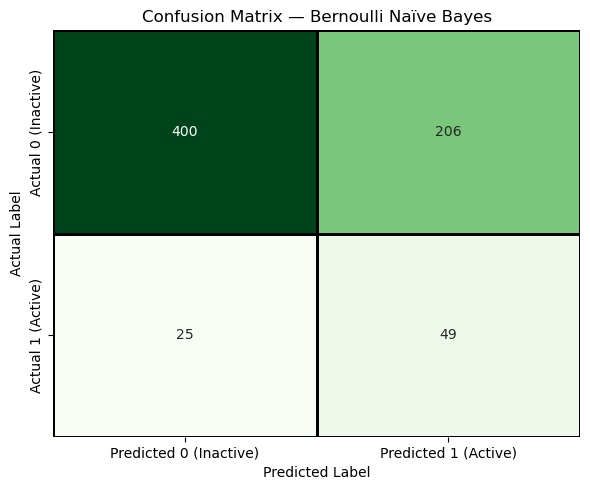

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 5))

sns.heatmap(
    CMat,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=False,
    xticklabels=["Predicted 0 (Inactive)", "Predicted 1 (Active)"],
    yticklabels=["Actual 0 (Inactive)", "Actual 1 (Active)"],
    linewidths=1,
    linecolor="black"
)

plt.title("Confusion Matrix — Bernoulli Naïve Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

plt.tight_layout()
plt.show()



The diagonal cells represent correct predictions, while the off-diagonal cells represent errors. The confusion matrix makes it visually clear that different types of errors occur, which is why we need multiple evaluation metrics rather than a single accuracy value

## 4.5 Confusion Matrix Based Evaluation Metrics
The confusion matrix reveals which kinds of mistakes the model makes.

|                     | **Predicted Inactive**  | **Predicted Active**    |
| ------------------- | ----------------------- | ----------------------- |
| **Actual Inactive** | **TN** (True Negative)  | **FP** (False Positive) |
| **Actual Active**   | **FN** (False Negative) | **TP** (True Positive)  |  



### 4.5.1 Table of Confusion Matrix Metrics
All the metrics below are derived from TN, TP, FN & FP and summarize the model's validity (mistakes) from different scientific perspectives.
| Metric                   | Mathematical Definition                                                                                    | What This Metric Tells Us                                                             |
| ------------------------ | ---------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------- |
| **Accuracy**             | $\displaystyle \frac{TP + TN}{TP + TN + FP + FN}$                                                          | What fraction of all predictions—active and inactive—were correct overall.            |
| **Precision**            | $\displaystyle \frac{TP}{TP + FP}$                                                                         | When the model predicts “active,” how often is it actually correct?                   |
| **Sensitivity (Recall)** | $\displaystyle \frac{TP}{TP + FN}$                                                                         | Of all truly active compounds, how many did the model successfully identify?          |
| **Specificity**          | $\displaystyle \frac{TN}{TN + FP}$                                                                         | Of all truly inactive compounds, how many did the model correctly reject?             |
| **Balanced Accuracy**    | $\displaystyle \frac{\text{Sensitivity} + \text{Specificity}}{2}$                                          | How well the model performs across both classes, even when the dataset is imbalanced. |
| **F1 Score**             | $\displaystyle \frac{2,(\text{Precision}\times\text{Sensitivity})}{\text{Precision} + \text{Sensitivity}}$ | A single score that balances finding actives with avoiding false positives.           |

In [39]:
# --- Test metrics ---
acc_test  = accuracy_score(y_test, y_test_pred)
prec_test = TP / (TP + FP) if (TP + FP) else 0.0
sens_test = TP / (TP + FN) if (TP + FN) else 0.0
spec_test = TN / (TN + FP) if (TN + FP) else 0.0
bacc_test = (sens_test + spec_test) / 2
f1_test   = (2 * prec_test * sens_test / (prec_test + sens_test)) if (prec_test + sens_test) else 0.0

print("TEST SET PERFORMANCE")
print(f"Accuracy          = {acc_test:.4f}")
print(f"Precision         = {prec_test:.4f}")
print(f"Sensitivity       = {sens_test:.4f}")
print(f"Specificity       = {spec_test:.4f}")
print(f"Balanced Accuracy = {bacc_test:.4f}")
print(f"F1 Score          = {f1_test:.4f}")

TEST SET PERFORMANCE
Accuracy          = 0.6603
Precision         = 0.1922
Sensitivity       = 0.6622
Specificity       = 0.6601
Balanced Accuracy = 0.6611
F1 Score          = 0.2979


The key takeaway from this discussion is that confusion-matrix-based metrics describe model performance at a single decision threshold, and some of those metrics, especially precision and F1, are highly sensitive to class imbalance. As a result, a model may contain useful discriminatory information while still appearing unreliable at a particular cutoff. Before deciding whether a model is truly useful, we therefore need a way to evaluate its ability to separate actives from inactives independently of any single threshold. This motivates a ranking-based evaluation using the ROC–AUC curve, which assesses whether the model assigns higher scores to active compounds than to inactive ones across all possible decision thresholds.

<div class="alert alert-block alert-warning">
Evaluation of the Confusion Matrix will continue in<strong><a href="../../../appendices/A-10-3_ConfusionMatrix.ipynb"> Module 10_3_Model Evaluation</a> </strong>, but before we do this we need to introduce probability-based inference and ROC-AUC
</div>

# 5. Probability-Based Inference (`.predict_proba`)

Up to this point, we have evaluated our classifier using a confusion matrix and metrics derived from it (accuracy, sensitivity, specificity, etc.). All of those metrics are based on a single decision rule: the model assigns each compound to a class (active or inactive) using a fixed threshold. This raises an important question:

> *What if the model is capable of separating actives from inactives, but the particular threshold we chose is not ideal?*

The key limitation of a confusion matrix is that it evaluates the model at only one operating point—that is, at a single decision threshold. If that threshold is poorly chosen, the model may appear to perform badly even when it has learned meaningful structure in the data.

The ROC curve (Receiver Operating Characteristic curve) addresses this limitation by evaluating the model across all possible decision thresholds. At one extreme, when the threshold is set to 1, no compounds are predicted active; at the other extreme, when the threshold is set to 0, all compounds are predicted active. As the threshold is gradually lowered between these extremes, the ROC curve traces how the true positive rate (sensitivity) increases in relation to the false positive rate, revealing the trade-off between correctly identifying actives and incorrectly flagging inactives.

Historically, the term “receiver operating characteristic” comes from signal-detection theory, where it described how a signal receiver’s performance changed as its detection sensitivity was adjusted. In machine learning, the same idea applies: the ROC curve characterizes how a classifier’s behavior changes as we vary the decision rule that converts scores into classifications.

The AUC (Area Under the Curve) then condenses this threshold-sweep into a single number, representing the integrated area under the ROC curve. Conceptually, AUC measures how well the model can rank compounds independent of any particular cutoff: if active compounds tend to receive higher scores than inactive ones, the AUC will be high, even if no single threshold has yet been chosen.

In this way, ROC–AUC answers a different question than the confusion matrix:

* Confusion matrices ask: *“How did the model perform at this particular decision rule?”*
* ROC–AUC asks: *“Across all possible decision rules, does the model separate actives from inactives at all?”*

This distinction is especially important in imbalanced datasets, where accuracy and related metrics can be misleading. A model may appear weak at a single threshold while still containing useful discriminatory information. ROC–AUC allows us to detect whether that underlying signal exists before we commit to a specific classification cutoff.

In the next steps, we will compute ROC–AUC using the same trained model as before. The only change will be how we interpret its output: instead of hard class labels, we will use the model’s continuous scores. Once we understand how well the model separates the classes in general, we can then return to the question of choosing an appropriate threshold for a specific scientific or practical objective.

<div class="alert alert-block alert-info">
<strong>Reality Check: What Do We Mean by “Threshold”?</strong>  The word <em>threshold</em> appears in both experimental science and machine learning, but it refers to two very different ideas. Confusing these meanings can make ROC–AUC feel mysterious or even misleading.

<p><strong>Discussion question:</strong><br>
When we talk about a “threshold” in ROC analysis, are we talking about the same kind of threshold that defines whether a compound is active or inactive in a bioassay?</p>
<div class="alert alert-block alert-success">
<details>
  <summary>Explanation</summary>

  <p><strong>No — these are fundamentally different thresholds.</strong></p>

  <p><strong>Experimental (bioassay) threshold:</strong><br>
  In an assay, a threshold is part of how the <em>labels are defined</em>. For example, a compound might be called “active” if its IC<sub>50</sub> is below a certain concentration. This threshold is tied to biology, chemistry, and experimental design. Once chosen, it defines the ground truth labels used for modeling.</p>

  <p><strong>Model (decision) threshold:</strong><br>
  In machine learning, the threshold does <em>not</em> change the experimental labels. Instead, it controls how the model’s <em>continuous output</em> (such as a predicted probability of being active) is converted into a hard class prediction (active vs inactive).</p>

  <p>For example, a model might assign a compound a score of 0.62 for being active. If we choose a decision threshold of 0.50, the model predicts “active.” If we choose a threshold of 0.70, the same compound would be predicted “inactive.” The underlying experimental label has not changed — only the model’s decision rule has.</p>

  <p><strong>Why this matters for ROC–AUC:</strong><br>
ROC–AUC is fundamentally a ranking-based evaluation. Rather than measuring performance at a single cutoff, it evaluates whether the model’s scores induce a ranked ordering in which truly active compounds tend to receive higher scores than truly inactive ones. The higher the AUC, the greater the probability that a randomly chosen active compound outranks a randomly chosen inactive compound.

As the decision threshold is varied from 1 to 0, we are effectively sliding a cutoff down this ranked list. Each possible threshold corresponds to a different point on the ROC curve. If the ranking meaningfully separates actives from inactives, then there will exist one or more thresholds that produce useful classification performance.

The AUC summarizes this idea by measuring how consistently the model ranks active compounds ahead of inactive ones, independent of where the cutoff is ultimately placed. If AUC is close to 0.5, the ranking is essentially random and no threshold will meaningfully separate the classes. If AUC is high, the ranking contains real discriminatory information, and the remaining task becomes choosing an appropriate threshold to turn that ranking into decisions.  ROC analysis explores <em>all possible decision thresholds</em> applied to the model’s scores. It asks whether the model tends to assign higher scores to truly active compounds than to truly inactive ones, regardless of where we ultimately place the cutoff.</p>

</details>
</div>
</details>

In [40]:
# 1. Imports
from pathlib import Path
import numpy as np

from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

#2 Load arrays (uncomment if SPLIT_ROOT is not in memory)
#SPLIT_ROOT = Path("data/AID743139/splits/90_10/arrays")

X_train = np.load(SPLIT_ROOT / "X_train.npy")
X_test  = np.load(SPLIT_ROOT / "X_test.npy")
y_train = np.load(SPLIT_ROOT / "y_train.npy")
y_test  = np.load(SPLIT_ROOT / "y_test.npy")

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 3. Balance the training set
idx_inactives = np.where(y_train == 0)[0]
idx_actives   = np.where(y_train == 1)[0]

num_actives = len(idx_actives)

np.random.seed(0)
idx_inactives_downsampled = np.random.choice(
    idx_inactives,
    size=num_actives,
    replace=False
)

X_train_bal = np.vstack((
    X_train[idx_inactives_downsampled],
    X_train[idx_actives]
))

y_train_bal = np.hstack((
    y_train[idx_inactives_downsampled],
    y_train[idx_actives]
))

print(X_train_bal.shape, y_train_bal.shape)


(6113, 162) (6113,)
(680, 162) (680,)
(1338, 162) (1338,)


In [41]:
# 4 Fit model
clf = BernoulliNB()
clf.fit(X_train_bal, y_train_bal)

#5 Predict Hard Labels
y_pred_test  = clf.predict(X_test)
y_pred_train = clf.predict(X_train_bal)

# 6. Create confusion matrices (train and test)

CMat_test  = confusion_matrix(y_test, y_pred_test)
CMat_train = confusion_matrix(y_train_bal, y_pred_train)

TN, FP, FN, TP = CMat_test.ravel()
TN_tr, FP_tr, FN_tr, TP_tr = CMat_train.ravel()

print("Test confusion matrix:\n", CMat_test)
print("\nTraining confusion matrix:\n", CMat_train)


Test confusion matrix:
 [[400 206]
 [ 25  49]]

Training confusion matrix:
 [[457 212]
 [187 482]]


In [42]:
# 7. Metrics from confusion matrices
# --- Test metrics ---
acc_test  = accuracy_score(y_test, y_pred_test)
prec_test = TP / (TP + FP) if (TP + FP) else 0.0
sens_test = TP / (TP + FN) if (TP + FN) else 0.0
spec_test = TN / (TN + FP) if (TN + FP) else 0.0
bacc_test = (sens_test + spec_test) / 2
f1_test   = (2 * prec_test * sens_test / (prec_test + sens_test)) if (prec_test + sens_test) else 0.0

print("TEST SET PERFORMANCE")
print(f"Accuracy          = {acc_test:.4f}")
print(f"Precision         = {prec_test:.4f}")
print(f"Sensitivity       = {sens_test:.4f}")
print(f"Specificity       = {spec_test:.4f}")
print(f"Balanced Accuracy = {bacc_test:.4f}")
print(f"F1 Score          = {f1_test:.4f}")

# --- Training metrics ---
acc_train  = accuracy_score(y_train_bal, y_pred_train)
prec_train = TP_tr / (TP_tr + FP_tr) if (TP_tr + FP_tr) else 0.0
sens_train = TP_tr / (TP_tr + FN_tr) if (TP_tr + FN_tr) else 0.0
spec_train = TN_tr / (TN_tr + FP_tr) if (TN_tr + FP_tr) else 0.0
bacc_train = (sens_train + spec_train) / 2
f1_train   = (2 * prec_train * sens_train / (prec_train + sens_train)) if (prec_train + sens_train) else 0.0

print("\nTRAINING SET PERFORMANCE")
print(f"Accuracy          = {acc_train:.4f}")
print(f"Precision         = {prec_train:.4f}")
print(f"Sensitivity       = {sens_train:.4f}")
print(f"Specificity       = {spec_train:.4f}")
print(f"Balanced Accuracy = {bacc_train:.4f}")
print(f"F1 Score          = {f1_train:.4f}")


TEST SET PERFORMANCE
Accuracy          = 0.6603
Precision         = 0.1922
Sensitivity       = 0.6622
Specificity       = 0.6601
Balanced Accuracy = 0.6611
F1 Score          = 0.2979

TRAINING SET PERFORMANCE
Accuracy          = 0.7018
Precision         = 0.6945
Sensitivity       = 0.7205
Specificity       = 0.6831
Balanced Accuracy = 0.7018
F1 Score          = 0.7073


In [43]:
#8. Get probablilty scores
y_score_test  = clf.predict_proba(X_test)[:, 1]
y_score_train = clf.predict_proba(X_train_bal)[:, 1]

#9. Compute ROC-AUC (train and test)
auc_test  = roc_auc_score(y_test, y_score_test)
auc_train = roc_auc_score(y_train_bal, y_score_train)

print("ROC–AUC")
print(f"Test AUC     = {auc_test:.4f}")
print(f"Training AUC = {auc_train:.4f}")



ROC–AUC
Test AUC     = 0.7279
Training AUC = 0.7546


In [44]:
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_score_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_bal, y_score_train)

print(
    f"ROC curve arrays (test set):\n"
    f"  fpr_test        = {fpr_test.shape}  # False Positive Rate values\n"
    f"  tpr_test        = {tpr_test.shape}  # True Positive Rate values\n"
    f"  thresholds_test = {thresholds_test.shape}  # Decision thresholds\n"
)

print(
    f"ROC curve arrays (test set):\n"
    f"  fpr_train        = {fpr_train.shape}  # False Positive Rate values\n"
    f"  tpr_train        = {tpr_train.shape}  # True Positive Rate values\n"
    f"  thresholds_train = {thresholds_train.shape}  # Decision thresholds\n"
)



ROC curve arrays (test set):
  fpr_test        = (144,)  # False Positive Rate values
  tpr_test        = (144,)  # True Positive Rate values
  thresholds_test = (144,)  # Decision thresholds

ROC curve arrays (test set):
  fpr_train        = (587,)  # False Positive Rate values
  tpr_train        = (587,)  # True Positive Rate values
  thresholds_train = (587,)  # Decision thresholds



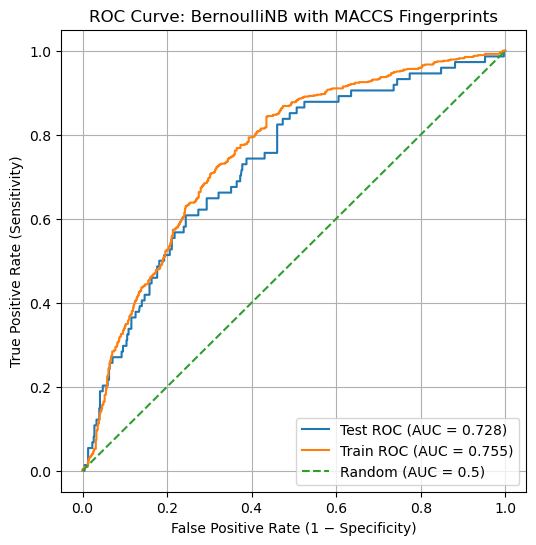

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Plot ROC curves
plt.plot(fpr_test,  tpr_test,  label=f"Test ROC (AUC = {auc_test:.3f})")
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.3f})")

# Reference line: random classifier
plt.plot([0, 1], [0, 1], linestyle='--', label="Random (AUC = 0.5)")

# Labels and title
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve: BernoulliNB with MACCS Fingerprints")

plt.legend(loc="lower right")
plt.grid(True)

plt.show()


The ROC curves for both the training and test sets lie well above the diagonal reference line, indicating that the model has learned a meaningful ranking signal rather than behaving like a random classifier. The training curve consistently exceeds the test curve, as expected, but the gap between them is modest, suggesting limited overfitting and reasonable generalization. The test-set AUC of approximately 0.72 confirms that active compounds tend to receive higher scores than inactive compounds, even though no single decision threshold has yet been chosen. At the same time, the gradual rise of the curve highlights an inherent trade-off: increasing sensitivity necessarily increases the false positive rate. This reinforces the idea that ROC–AUC evaluates whether useful separation exists at all, while the choice of a specific threshold must be guided by scientific or practical priorities.

<div class="alert alert-block alert-success">

<H1>Homework</H1>
<strong>Problem 1: hw_10.2my_AID.ipynb</strong> 
<p>Make a new notebook called hw_10.2my_AID.ipynb and place it in the directory you have been runnin this notebook in.  You now need to create a confusion matric, and ROC and print out AOC values. I do not want you to generate all of the narrative of this notebook, just the code cells with maybe headers and a few markdown statements to assist someone in navigating the notebook. There are several approaches you can take, for example, you could make a copy of this notebook, rename it, delete the bulk of the markdown cells, and then use refactoring to change the AID used in this notebook to your AID.  Or you may want to open the Jupyter book in another cell, and just copy those cells you need for the workflow.  You need to use the paths techniques and cinf26pk, so I can load your completed notebook and generate the data artifacts within the directory architecture we are developing in this class
    
</p>
</div>